## Project

### Preprocessing data

In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.read_excel('AirQualityUCI.xlsx')
df['time_str'] = df['Time'].astype(str)

# Combine "date" and "time_str" columns into a new "datetime" column
df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['time_str'])

# Drop the original "date" and "time" columns if needed
df.drop(['Date', 'Time', 'time_str'], axis=1, inplace=True)
df.head(2)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,datetime
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.6,48.875001,0.757754,2004-03-10 18:00:00
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.3,47.700000,0.725487,2004-03-10 19:00:00


In [11]:
datetime_column = df.pop('datetime')
df.insert(0, 'datetime', datetime_column)
df.replace(-200, float('nan'), inplace=True)
# df.isnull().sum() # check how many null value in each column

# df = df.drop(columns= "NMHC(GT)") # too many missing values
df = df.fillna(df.mean(numeric_only=True)) # replaces all NaN values with the mean value of each column
# df.isnull().sum()
df = df.astype({col: 'float32' for col in df.select_dtypes('float64').columns})

In [59]:
print(df.dtypes)
print(df.shape)
print(df.size)

datetime         datetime64[ns]
CO(GT)                  float32
PT08.S1(CO)             float32
NMHC(GT)                float32
C6H6(GT)                float32
PT08.S2(NMHC)           float32
NOx(GT)                 float32
PT08.S3(NOx)            float32
NO2(GT)                 float32
PT08.S4(NO2)            float32
PT08.S5(O3)             float32
T                       float32
RH                      float32
AH                      float32
dtype: object
(9357, 14)
130998


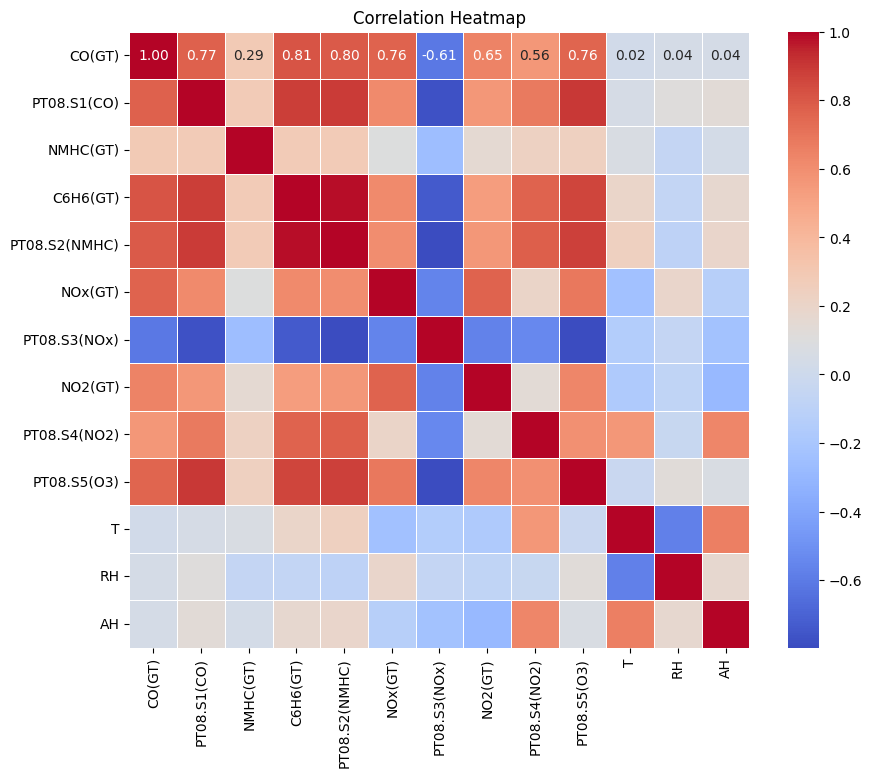

In [12]:
import seaborn as sns
# Create a heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [13]:
# Replace 'column_name' with the name of your column
unique_values_count = df['CO(GT)'].nunique()

print(f'The column has {unique_values_count} unique values.')


The column has 97 unique values.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame and 'T' and 'CO(GT)' are the columns of interest
# If there are more features, you can use them as well.

# Standardize the data
features = ['T', 'CO(GT)']
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Choose the number of clusters
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Plot the clustered data
plt.figure(figsize=(10, 6))
for cluster in np.unique(df['Cluster']):
    subset = df[df['Cluster'] == cluster]
    plt.scatter(subset['T'], subset['CO(GT)'], label=f'Cluster {cluster}')

plt.xlabel('Temperature (T)')
plt.ylabel('CO(GT) Levels')
plt.title('Clusters of Original Data')
plt.legend()
plt.show()


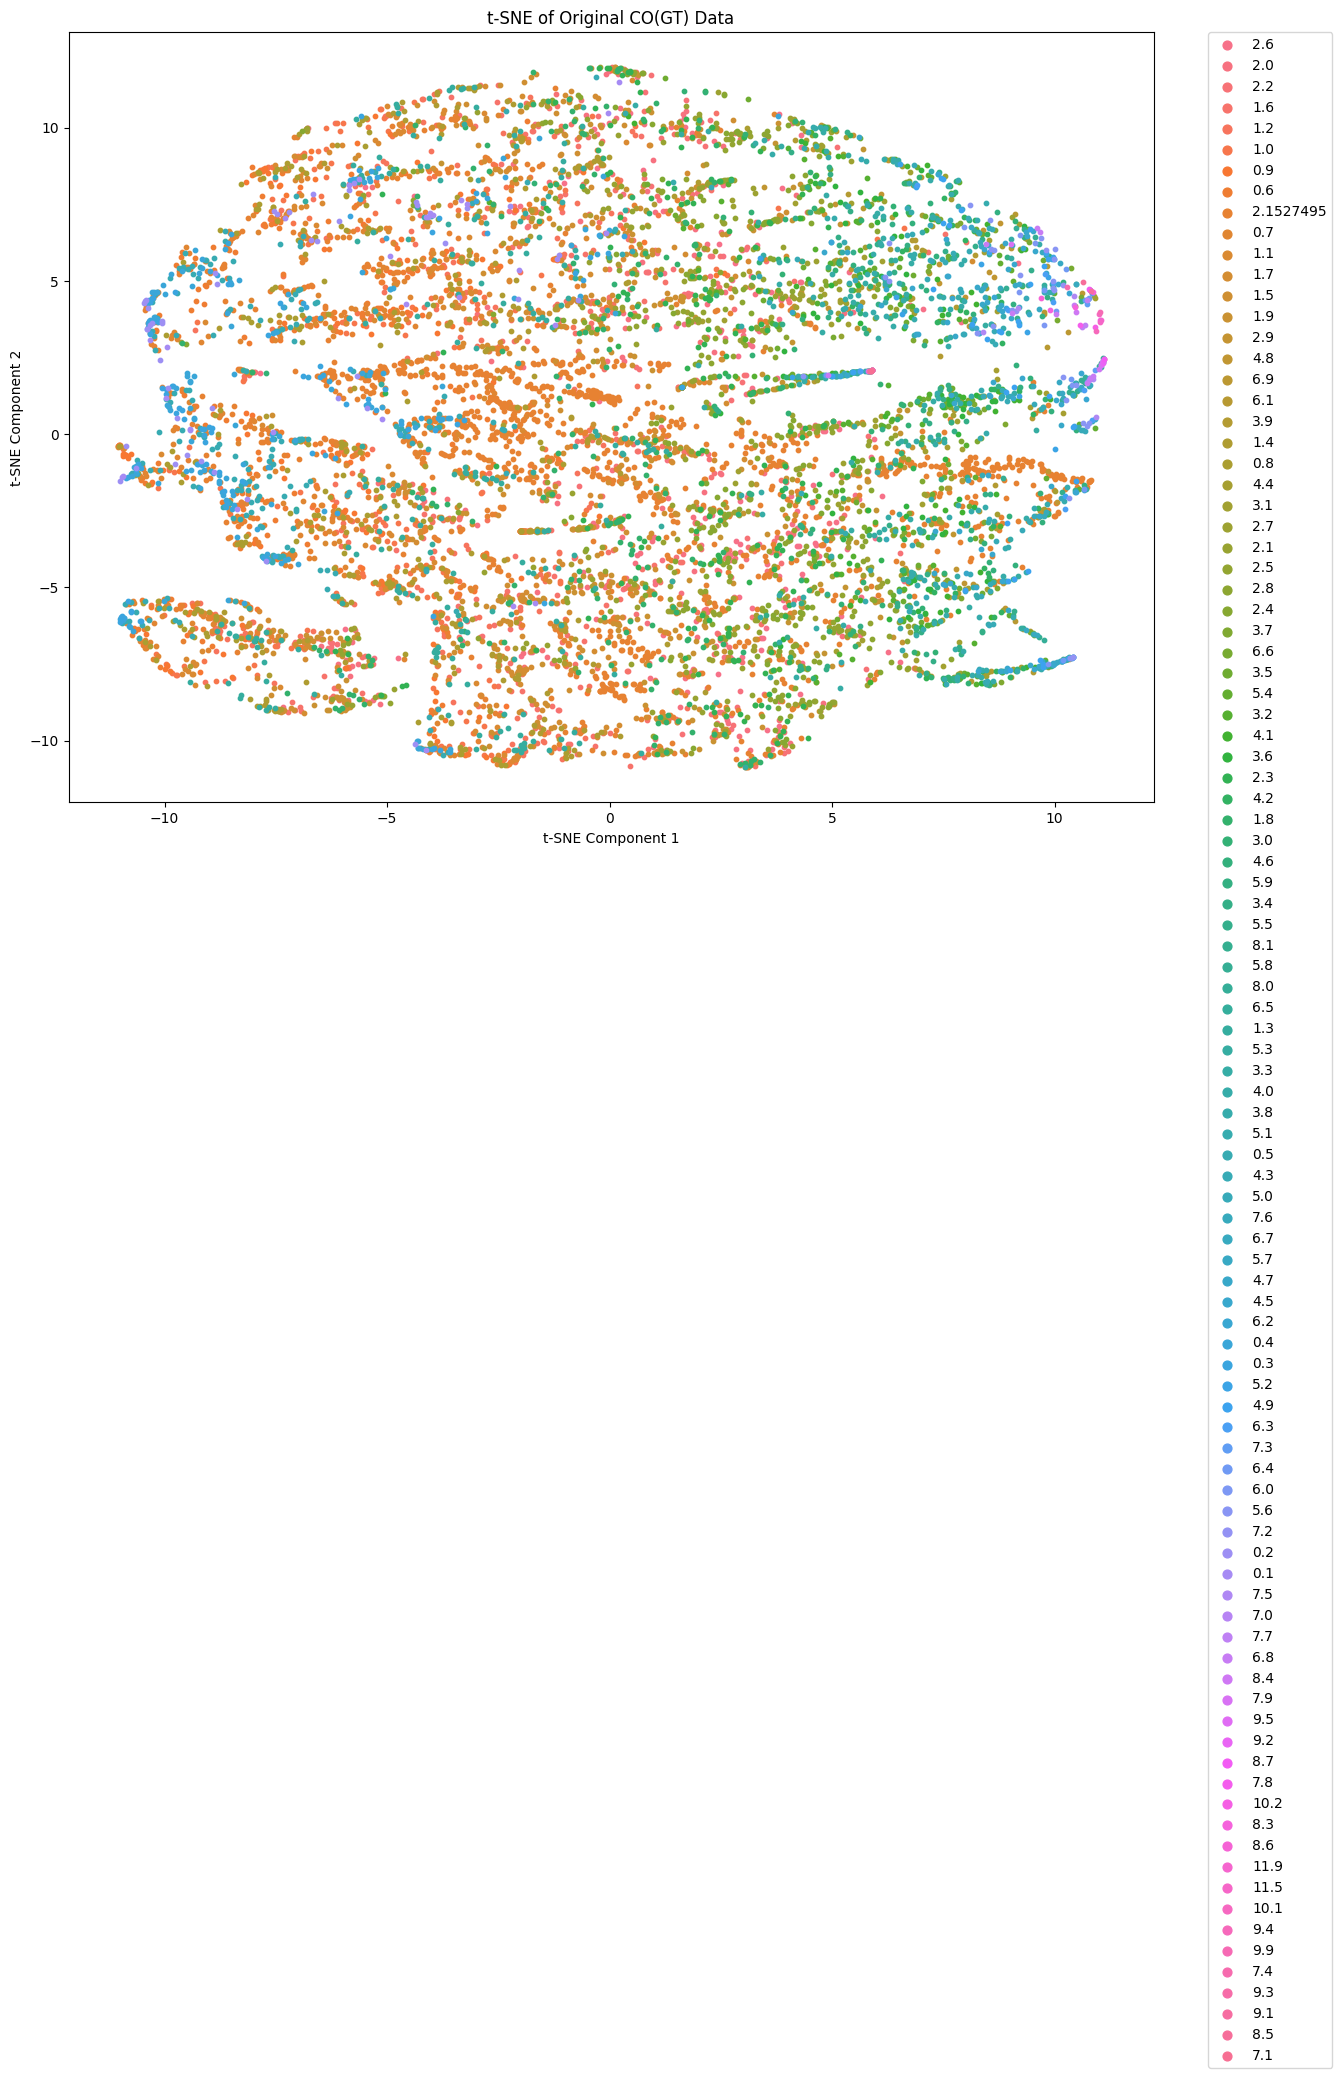

In [16]:
from sklearn.manifold import TSNE

# df = df.drop(columns= "datetime")
features = df.drop(columns=['CO(GT)'])  # 'target_column'
target = df['CO(GT)']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_components = tsne.fit_transform(features_scaled)
tsne_df = pd.DataFrame(data=tsne_components, columns=['TSNE1', 'TSNE2'])

# Combine with the target
final_tsne_df = pd.concat([tsne_df, target], axis=1)

# Get unique labels and assign colors
unique_labels = final_tsne_df['CO(GT)'].unique()
num_labels = len(unique_labels)
palette = sns.color_palette("husl", num_labels)

# Create a dictionary mapping labels to colors
label_color_dict = {label: palette[i] for i, label in enumerate(unique_labels)}

# Plot the t-SNE result
plt.figure(figsize=(14, 10))
for label in unique_labels:
    indices = final_tsne_df['CO(GT)'] == label
    plt.scatter(final_tsne_df.loc[indices, 'TSNE1'], final_tsne_df.loc[indices, 'TSNE2'], 
                color=label_color_dict[label], label=label, s=10)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Original CO(GT) Data')
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


### ICA

In [4]:
# ICA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
import pandas as pd

datetime_col = df['datetime']
numerical_cols = df.drop('datetime', axis=1)

# Preprocessing: Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_cols)

# Combine the normalized numerical columns with the datetime column
scaled_df = pd.DataFrame(scaled_data, columns=numerical_cols.columns)
scaled_df.insert(0, 'datetime', datetime_col)

# number of components
n_components = 5

ica = FastICA(n_components=n_components, random_state=0)
ica_components = ica.fit_transform(scaled_data)

# Transform the data to get the independent components
df_ica = pd.DataFrame(ica_components, columns=[f'IC{i+1}' for i in range(n_components)])
df_ica.insert(0, 'datetime', datetime_col)
df_ica


,datetime,IC1,IC2,IC3,IC4,IC5
0,2004-03-10 18:00:00,1.768661,-0.221175,0.301038,0.536079,-1.266781
1,2004-03-10 19:00:00,1.681118,-0.296087,0.332470,0.217120,-1.691049
2,2004-03-10 20:00:00,1.548097,-0.009873,0.537707,0.342810,-1.360410
3,2004-03-10 21:00:00,1.379985,0.307639,0.631785,0.390771,-1.089044
4,2004-03-10 22:00:00,1.062965,0.271804,0.668241,0.127757,-1.255008
...,...,...,...,...,...,...
9352,2005-04-04 10:00:00,-0.199472,-1.263943,0.377081,0.317816,1.960551
9353,2005-04-04 11:00:00,-0.509864,-1.654435,0.201743,-0.217316,1.798593
9354,2005-04-04 12:00:00,-0.344026,-2.050165,0.038371,-0.347443,1.680926
9355,2005-04-04 13:00:00,-0.682233,-2.458403,0.076093,-0.608549,1.277033


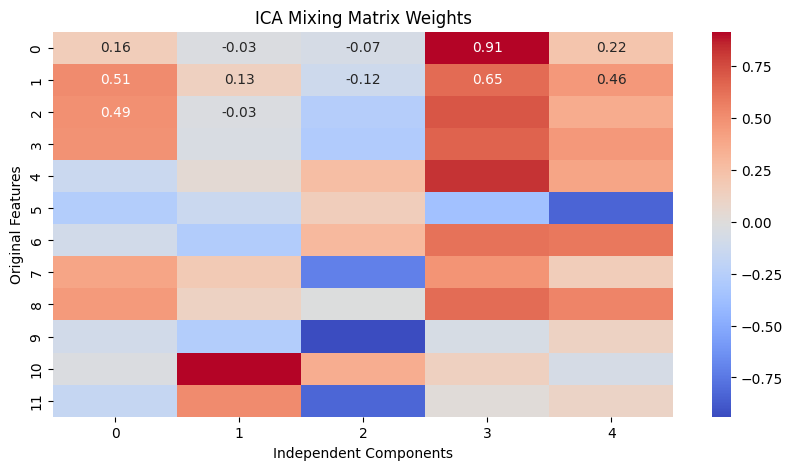

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'ica' is your fitted FastICA model
mixing_matrix = ica.mixing_

# Plotting the mixing matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(mixing_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('ICA Mixing Matrix Weights')
plt.xlabel('Independent Components')
plt.ylabel('Original Features')
plt.show()


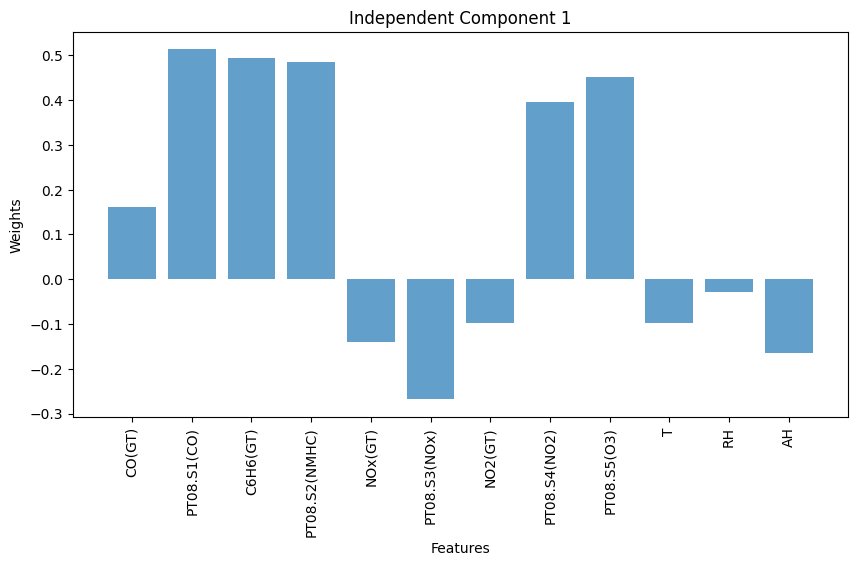

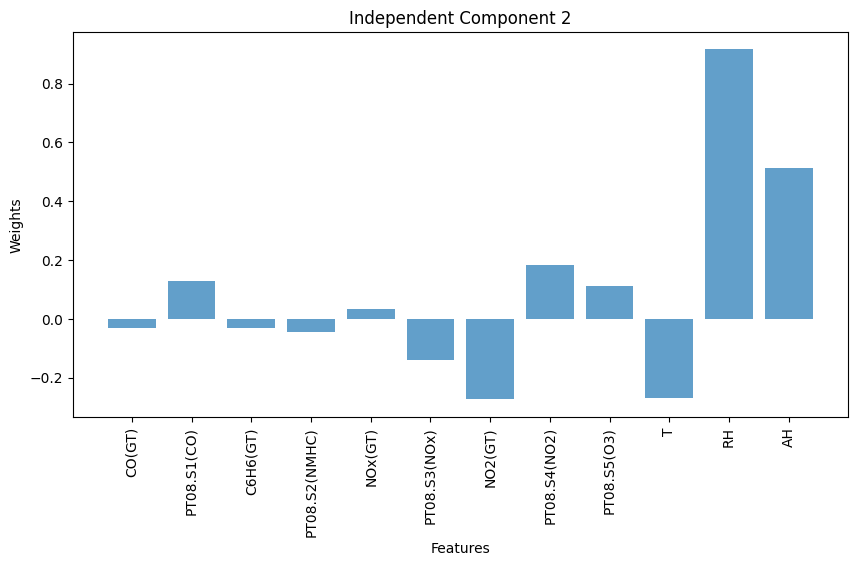

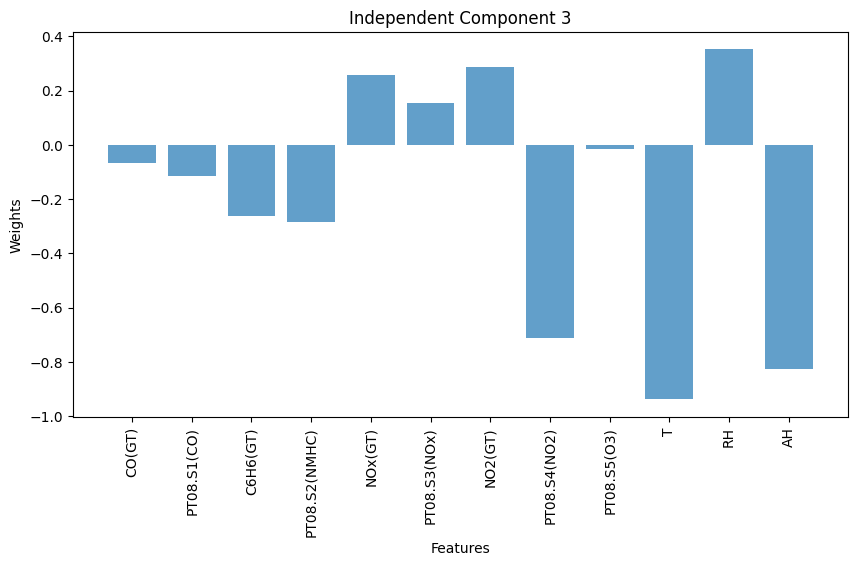

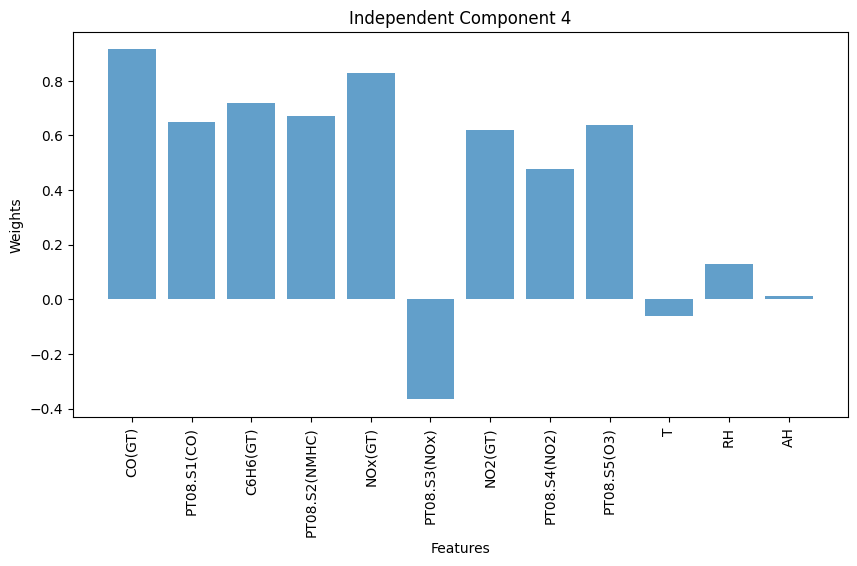

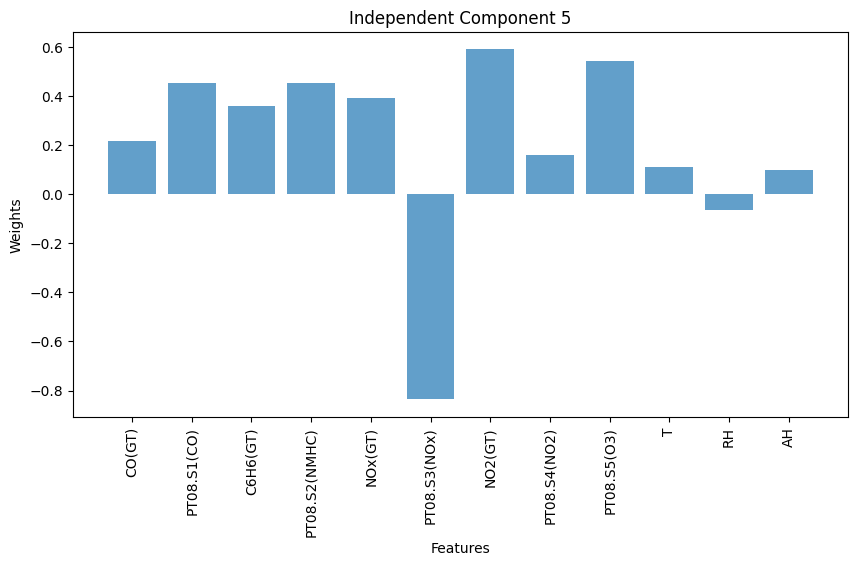

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'ica' is your fitted FastICA model and 'df' is your original DataFrame
mixing_matrix = ica.mixing_
feature_names = df.drop('datetime', axis=1).columns
n_components = mixing_matrix.shape[1]

# Create a bar chart for each independent component
for i in range(n_components):
    plt.figure(figsize=(10, 5))
    # Extract the weights for the i-th component
    weights = mixing_matrix[:, i]
    # Create an index for each tick position
    idx = np.arange(len(feature_names))
    plt.bar(idx, weights, align='center', alpha=0.7)
    plt.xticks(idx, feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Weights')
    plt.title(f'Independent Component {i+1}')
    plt.show()


### VAE

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape, Layer, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

def total_correlation(z, mean, log_var):
    # Calculate log(q(z|x)) - log(prod_i q(z_i|x))
    log_qz_given_x = -0.5 * (tf.reduce_sum(log_var + tf.square(z - mean) / tf.exp(log_var), axis=1) + tf.math.log(2 * np.pi))
    log_qz = tf.reduce_logsumexp(log_qz_given_x, axis=0) - tf.math.log(tf.cast(tf.shape(z)[0], tf.float32))
    log_prod_qzi_given_x = tf.reduce_sum(-0.5 * (log_var + tf.square(z - mean) / tf.exp(log_var) + tf.math.log(2 * np.pi)), axis=1)
    tc = tf.reduce_mean(log_qz - log_prod_qzi_given_x)
    return tc

class VAELossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        
        input_layer, reconstruction, mean_layer, log_var_layer, latent_space = inputs
        reconstruction_loss = MeanSquaredError()(input_layer, reconstruction)
        kl_loss = -0.5 * tf.reduce_sum(1 + log_var_layer - tf.square(mean_layer) - tf.exp(log_var_layer), axis=-1)
        
        # Calculate Total Correlation Loss
        tc_loss = total_correlation(latent_space, mean_layer, log_var_layer)

        total_loss = reconstruction_loss + kl_loss + tc_loss *0.1
        self.add_loss(tf.reduce_mean(total_loss))
        
        return reconstruction
    
class VAE:
    def __init__(self, input_shape, latent_dim):

        self.input_shape = input_shape  # This should be a tuple
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.vae = self.build_vae()

    def build_encoder(self):
        input_layer = Input(shape=self.input_shape)

        hidden_layer1 = Dense(512, activation='relu')(input_layer)  # Increased units
        hidden_layer2 = Dense(256, activation='relu')(hidden_layer1)
        hidden_layer3 = Dense(128, activation='relu')(hidden_layer2)
        hidden_layer4 = Dense(64, activation='relu')(hidden_layer3)  # Added layer

        #  the mean of the Gaussian distribution in the latent space
        mean_layer = Dense(self.latent_dim)(hidden_layer4)

        # the log of the variance of the Gaussian distribution in the latent space
        log_var_layer = Dense(self.latent_dim)(hidden_layer4)

        # reparameterization
        def sampling(args):
            mean, log_var = args            # the mean and log variance of the latent distribution
            batch = tf.shape(mean)[0]       # computes the batch size from the shape of the mean tensor
            dim = tf.shape(mean)[1]         # computes the dimensionality of the latent space from the shape of the mean tensor

            # generates a tensor of random values from a standard normal distribution with the same shape as the mean tensor
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return mean + tf.exp(0.5 * log_var) * epsilon  # applies the reparameterization trick
                                                           # allows the model to backpropagate gradients through the sampling operation

        latent_space = Lambda(sampling)([mean_layer, log_var_layer])

        encoder = Model(input_layer, [mean_layer, log_var_layer, latent_space], name='encoder')
        return encoder

    def build_decoder(self):
        latent_inputs = Input(shape=(self.latent_dim,))
        
        hidden_layer1 = Dense(64, activation='relu')(latent_inputs)
        hidden_layer2 = Dense(128, activation='relu')(hidden_layer1)
        hidden_layer3 = Dense(256, activation='relu')(hidden_layer2)
        hidden_layer4 = Dense(512, activation='relu')(hidden_layer3)  # Added layer
        
        flat_output = Dense(np.prod(self.input_shape), activation='sigmoid')(hidden_layer4)
        output_layer = Reshape(self.input_shape)(flat_output)  # Reshape output to match input shape

        decoder = Model(latent_inputs, output_layer, name='decoder')
        return decoder

    
    # In VAE class, modify the build_vae method to use the custom VAELossLayer
    def build_vae(self):
        input_layer = Input(shape=self.input_shape)
        mean_layer, log_var_layer, latent_space = self.encoder(input_layer)
        reconstruction = self.decoder(latent_space)

        # Use the custom VAELossLayer
        output_with_loss = VAELossLayer()([input_layer, reconstruction, mean_layer, log_var_layer, latent_space])

        vae = Model(input_layer, output_with_loss, name='vae')
        vae.compile(optimizer=Adam(learning_rate=0.001))  # Adjusted learning rate
        return vae


    def train(self, x_train, x_val, batch_size, epochs):
        # self.vae.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1)
        self.vae.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, x_val), verbose=1)

    def encode(self, x):
        return self.encoder.predict(x)

    def decode(self, z):
        return self.decoder.predict(z)
    
    def predict(self, x):
        # Reconstruct input data
        return self.vae.predict(x)


### Causal effect of 'Temperature' (T) on 'CO(GT)'

In [6]:
df.head(1)

,datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.0,150.0,11.881723,1045.5,166.0,1056.25,113.0,1692.0,1267.5,13.6,48.875,0.757754


In [7]:
df.shape

(9357, 14)

In [8]:
df['Timestamp'] = df['datetime'].astype(np.int64) / 10**9

# Drop the original datetime column
df.drop('datetime', axis=1, inplace=True)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

# Ensure data is a numpy array for TensorFlow
data_scaled = np.array(data_scaled)

x_train, x_val = train_test_split(data_scaled, test_size=0.2, random_state=42)

# Define and train the VAE
vae = VAE(input_shape=x_train.shape[1:], latent_dim=2)

vae.train(x_train, x_val, batch_size=64, epochs=50)

# vae.train(data_scaled, batch_size=32, epochs=30)



Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.1959 - val_loss: 1.1441
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1469 - val_loss: 1.1460
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1149 - val_loss: 1.1452
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1042 - val_loss: 1.1458
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1211 - val_loss: 1.1456
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0962 - val_loss: 1.1469
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1047 - val_loss: 1.1445
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1351 - val_loss: 1.1481
Epoch 9/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1228 - val_loss: 1.1463
Epoch 10/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1306 - val_loss: 1.1453
Epoch 11/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1212 - val_loss: 1.1461
Epoch 12/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

In [28]:
# Calculate reconstruction loss on the validation set
reconstructed_data = vae.predict(x_val)
reconstruction_loss = np.mean(np.square(x_val - reconstructed_data))
print(f'Reconstruction Loss: {reconstruction_loss}')

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Reconstruction Loss: 1.023717992046612


In [ ]:
def plot_reconstruction(model, x_val, num_images=10):
    samples = x_val[:num_images]
    reconstructions = model.predict(samples)
    
    for i in range(num_images):
        plt.figure(figsize=(10, 2))
        
        # Original sample
        plt.subplot(1, 2, 1)
        plt.plot(samples[i])
        plt.title("Original")
        
        # Reconstructed sample
        plt.subplot(1, 2, 2)
        plt.plot(reconstructions[i])
        plt.title("Reconstructed")
        
        plt.show()

plot_reconstruction(vae.vae, x_val)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\fengyong\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\fengyong\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


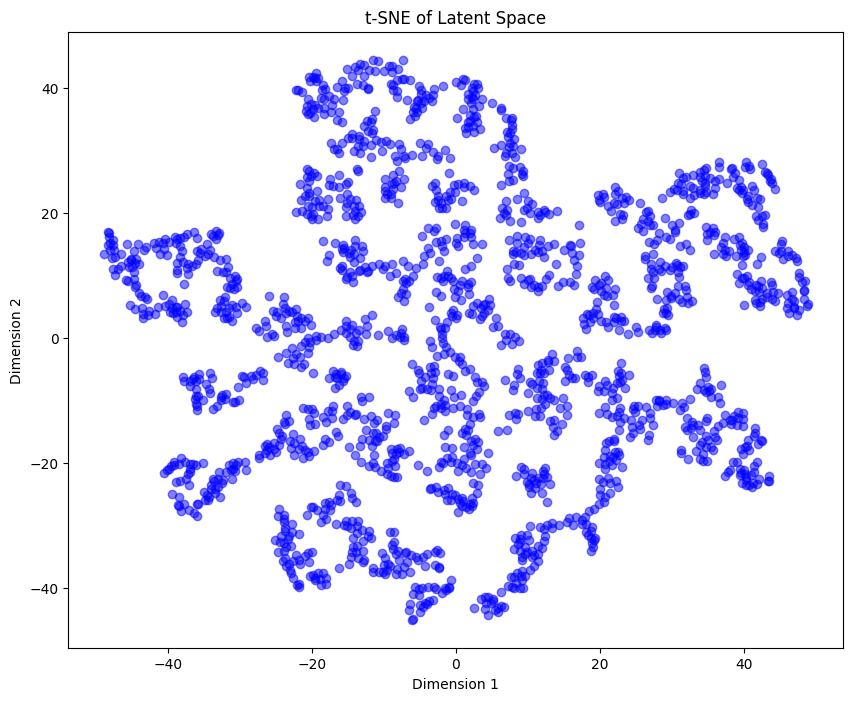

In [11]:
from sklearn.manifold import TSNE

# Visualize the latent space
def plot_latent_space(encoder, x_val):
    mean, _, latent_space = encoder.predict(x_val)
    tsne = TSNE(n_components=2)
    z_tsne = tsne.fit_transform(latent_space)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c='blue', alpha=0.5)
    plt.title('t-SNE of Latent Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

plot_latent_space(vae.encoder, x_val)

In [12]:
# The latent space is effectively capturing the diversity and uniqueness of each data point or not
def check_latent_space_diversity(encoder, x_val):
    mean, _, latent_space = encoder.predict(x_val)
    unique_latent_vectors = np.unique(latent_space, axis=0)
    print(f'Number of unique latent vectors: {unique_latent_vectors.shape[0]} out of {latent_space.shape[0]} samples')

check_latent_space_diversity(vae.encoder, x_val) # it is capturing


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Number of unique latent vectors: 1872 out of 1872 samples


293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step


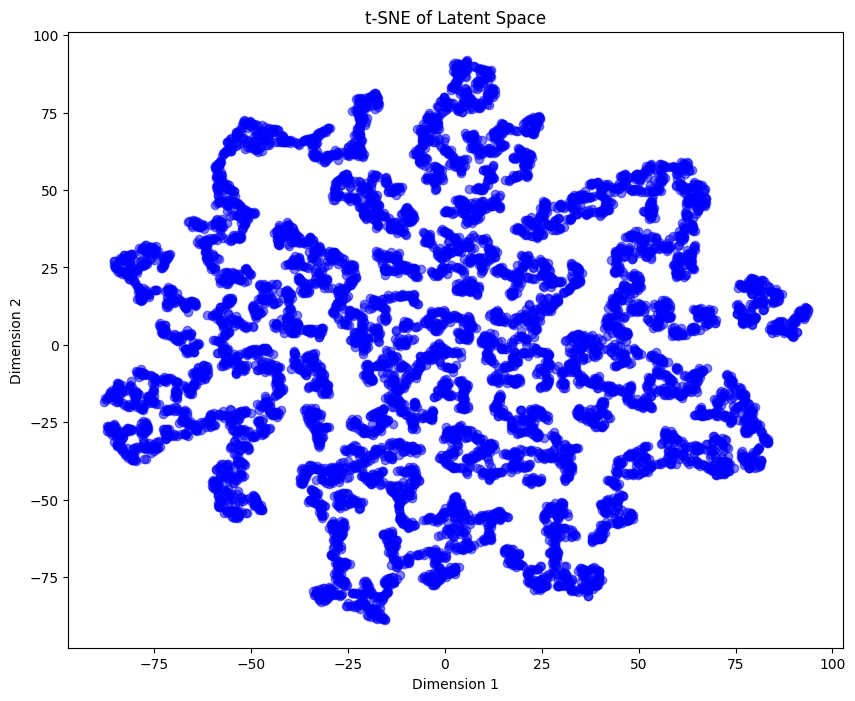

In [13]:
from sklearn.manifold import TSNE
def plot_latent_space(encoder, x_test):
    # Encode the dataset into the latent space
    _, _, latent_space = encoder.predict(x_test)
    
    # Use t-SNE to reduce the dimensionality of the latent space to 2D
    tsne = TSNE(n_components=2)
    z_tsne = tsne.fit_transform(latent_space)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c='blue', alpha=0.5)
    plt.title('t-SNE of Latent Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

plot_latent_space(vae.encoder, data_scaled)


In [14]:
def check_latent_space_diversity(encoder, data_scaled):
    mean, _, latent_space = encoder.predict(data_scaled)
    unique_latent_vectors = np.unique(latent_space, axis=0)
    print(f'Number of unique latent vectors: {unique_latent_vectors.shape[0]} out of {latent_space.shape[0]} samples')

check_latent_space_diversity(vae.encoder, data_scaled)

293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Number of unique latent vectors: 9357 out of 9357 samples


In [15]:
# After training, encode the data to get latent representations
latent_representations = vae.encode(data_scaled)

# analyze the latent representations to explore potential relationships
print(latent_representations)

293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
[array([[ 4.3093446e-06, -4.2459737e-06],
       [ 4.3093446e-06, -4.2459737e-06],
       [ 4.3093446e-06, -4.2459737e-06],
       ...,
       [ 4.3093446e-06, -4.2459737e-06],
       [ 4.3093446e-06, -4.2459737e-06],
       [ 4.3093446e-06, -4.2459737e-06]], dtype=float32), array([[-3.6117933e-07,  9.2660741e-07],
       [-3.6117933e-07,  9.2660741e-07],
       [-3.6117933e-07,  9.2660741e-07],
       ...,
       [-3.6117933e-07,  9.2660741e-07],
       [-3.6117933e-07,  9.2660741e-07],
       [-3.6117933e-07,  9.2660741e-07]], dtype=float32), array([[-0.3057483 ,  1.9567777 ],
       [-0.92660564,  0.30101672],
       [ 0.5633404 ,  0.8702434 ],
       ...,
       [-0.19821277,  0.20076936],
       [-0.5058816 , -0.5996393 ],
       [ 0.28200623, -1.4631588 ]], dtype=float32)]


The first array:  contains the values from the mean layer of the encoder.

The second array:  contains the values from the log variance layer of the encoder.

The third array:  contains the actual sampled latent space representations. (focus on it)

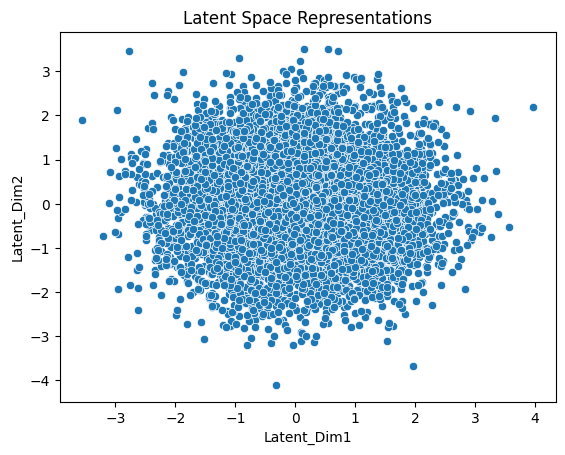

In [16]:
latent_space_representations = latent_representations[2]

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert to a DataFrame for easier manipulation and visualization
latent_df = pd.DataFrame(latent_space_representations, columns=['Latent_Dim1', 'Latent_Dim2'])

# Visualize the latent space
sns.scatterplot(x='Latent_Dim1', y='Latent_Dim2', data=latent_df)
plt.title('Latent Space Representations')
plt.show()

In [17]:
latent_df['T'] = df['T'].values
latent_df['RH'] = df['RH'].values

correlation_matrix = latent_df.corr()
print(correlation_matrix)

             Latent_Dim1  Latent_Dim2         T        RH
Latent_Dim1     1.000000    -0.016000  0.011337 -0.018877
Latent_Dim2    -0.016000     1.000000 -0.013407  0.008120
T               0.011337    -0.013407  1.000000 -0.578569
RH             -0.018877     0.008120 -0.578569  1.000000


analyze the causal effect of 'Temperature' (T) on 'CO(GT)'

In [18]:
import dowhy
from dowhy import CausalModel
import pandas as pd

# `df` is original DataFrame and `latent_df` contains the latent representations

# Choose your variables of interest
df['Latent_Dim1'] = latent_space_representations[:, 0]
df['Latent_Dim2'] = latent_space_representations[:, 1]

treatment = 'T'
outcome = 'CO(GT)'

# Create the causal model
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=['Latent_Dim1', 'Latent_Dim2','RH','AH'],  # Include other variables as needed
)

# Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                           
────(E[CO(GT)|Latent_Dim1,AH,Latent_Dim2,RH])
d[T]                                         
Estimand assumption 1, Unconfoundedness: If U→{T} and U→CO(GT) then P(CO(GT)|T,Latent_Dim1,AH,Latent_Dim2,RH,U) = P(CO(GT)|T,Latent_Dim1,AH,Latent_Dim2,RH)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [19]:

# Estimate the causal effect using a specified method
causal_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression")

print(causal_estimate)

# Mean value: On average, a one-unit increase in T is associated with a 0.0326 unit increase in CO(GT).

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                           
────(E[CO(GT)|Latent_Dim1,AH,Latent_Dim2,RH])
d[T]                                         
Estimand assumption 1, Unconfoundedness: If U→{T} and U→CO(GT) then P(CO(GT)|T,Latent_Dim1,AH,Latent_Dim2,RH,U) = P(CO(GT)|T,Latent_Dim1,AH,Latent_Dim2,RH)

## Realized estimand
b: CO(GT)~T+Latent_Dim1+AH+Latent_Dim2+RH
Target units: ate

## Estimate
Mean value: 0.032607189440317264



In [20]:
# Refute the causal effect estimate to check robustness
refutation = model.refute_estimate(identified_estimand, causal_estimate, method_name="placebo_treatment_refuter")
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:0.032607189440317264
New effect:-7.105427357601002e-15
p value:0.0



Causal estimation: temperature (T) has a small but positive effect on CO(GT). 

The robustness check using a placebo treatment shows that the estimated effect is likely robust, as the placebo treatment had no significant effect.

### iVAE

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape, Layer, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

class iVAELossLayer(Layer):
    def __init__(self, **kwargs):
        super(iVAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        input_layer, reconstruction, mean_layer, log_var_layer, condition_layer = inputs
        reconstruction_loss = MeanSquaredError()(input_layer, reconstruction)
        kl_loss = -0.5 * tf.reduce_sum(1 + log_var_layer - tf.square(mean_layer) - tf.exp(log_var_layer), axis=-1)
        
        condition_diff = tf.reduce_mean(tf.square(condition_layer - tf.stop_gradient(condition_layer)))
        total_loss = reconstruction_loss + kl_loss + condition_diff
        self.add_loss(tf.reduce_mean(total_loss))
        
        return reconstruction
    
class iVAE:
    def __init__(self, input_shape, latent_dim, condition_dim):
        self.input_shape = input_shape
        self.latent_dim = latent_dim

        self.condition_dim = condition_dim
        
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.vae = self.build_vae()

    def build_encoder(self):
        input_layer = Input(shape=self.input_shape)
        condition_layer = Input(shape=(self.condition_dim,))
        
        concat_input = tf.keras.layers.Concatenate()([input_layer, condition_layer])
        
        hidden_layer1 = Dense(256, activation='relu')(concat_input)
        hidden_layer2 = Dense(128, activation='relu')(hidden_layer1)
        hidden_layer3 = Dense(64, activation='relu')(hidden_layer2)

        mean_layer = Dense(self.latent_dim)(hidden_layer3)
        log_var_layer = Dense(self.latent_dim)(hidden_layer3)

        def sampling(args):
            mean, log_var = args
            batch = tf.shape(mean)[0]
            dim = tf.shape(mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return mean + tf.exp(0.5 * log_var) * epsilon

        latent_space = Lambda(sampling)([mean_layer, log_var_layer])

        encoder = Model([input_layer, condition_layer], [mean_layer, log_var_layer, latent_space, condition_layer], name='encoder')
        return encoder

    def build_decoder(self):
        latent_inputs = Input(shape=(self.latent_dim,))
        condition_layer = Input(shape=(self.condition_dim,))
        
        concat_latent = tf.keras.layers.Concatenate()([latent_inputs, condition_layer])
        
        hidden_layer1 = Dense(64, activation='relu')(concat_latent)
        hidden_layer2 = Dense(128, activation='relu')(hidden_layer1)
        hidden_layer3 = Dense(256, activation='relu')(hidden_layer2)
        
        flat_output = Dense(np.prod(self.input_shape), activation='sigmoid')(hidden_layer3)
        output_layer = Reshape(self.input_shape)(flat_output)

        decoder = Model([latent_inputs, condition_layer], output_layer, name='decoder')
        return decoder

    def build_vae(self):
        input_layer = Input(shape=self.input_shape)
        condition_layer = Input(shape=(self.condition_dim,))
        
        mean_layer, log_var_layer, latent_space, condition_output = self.encoder([input_layer, condition_layer])
        reconstruction = self.decoder([latent_space, condition_layer])

        output_with_loss = iVAELossLayer()([input_layer, reconstruction, mean_layer, log_var_layer, condition_output])

        vae = Model([input_layer, condition_layer], output_with_loss, name='vae')
        vae.compile(optimizer=Adam(learning_rate=0.001))
        return vae

    def train(self, x_train, condition_train, batch_size, epochs):
        self.vae.fit([x_train, condition_train], x_train, batch_size=batch_size, epochs=epochs, verbose=1)

    def encode(self, x, c):
        return self.encoder.predict([x, c])

    def decode(self, z, c):
        return self.decoder.predict([z, c])
    
    def predict(self, x, c):
        return self.vae.predict([x, c])
    

### iVAE: Causal effect of 'Temperature' (T) on 'CO(GT)' 

Make 'Temperature' as the condition in iVAE model.

In [50]:
from sklearn.preprocessing import StandardScaler
# Extract features (excluding 'T') and the condition ('T')
features = df[['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)','C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
               'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'RH', 'AH']].values
condition = df[['T']].values

feature_scaler = StandardScaler()
condition_scaler = StandardScaler()

features_scaled = feature_scaler.fit_transform(features)
condition_scaled = condition_scaler.fit_transform(condition)

features_scaled = np.array(features_scaled)
condition_scaled = np.array(condition_scaled)

In [51]:
input_shape = (features_scaled.shape[1], )  # Features shape (excluding condition)
latent_dim = 2 
condition_dim = 1  # Condition dimension for 'Temperature'

vae = iVAE(input_shape=input_shape, latent_dim=latent_dim, condition_dim=condition_dim)
vae.train(features_scaled, condition_scaled, batch_size=32, epochs=30)

latent_representations = vae.encode(features_scaled, condition_scaled)


Epoch 1/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0163
Epoch 2/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9462
Epoch 3/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9505
Epoch 4/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9352
Epoch 5/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9635
Epoch 6/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9433
Epoch 7/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9639
Epoch 8/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9591
Epoch 9/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9494
Epoch 10/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9590
Epoch 11/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9585
Epoch 12/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9546
Epoch 13/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9631
Epoch 14/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9342
Epoch 15/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [52]:
print(latent_representations)

# Array 1: Mean values of the latent space distribution.
# Array 2: Log variance values of the latent space distribution.
# Array 3: Latent space values (samples).
# Array 4: Condition variable values.

[array([[ 0.00169927, -0.00157337],
       [ 0.00270141, -0.00365554],
       [ 0.00292592, -0.00412202],
       ...,
       [-0.00058826,  0.00317951],
       [-0.00105501,  0.00414929],
       [-0.00109529,  0.00423297]], dtype=float32), array([[ 0.00131476, -0.00018884],
       [ 0.00094062,  0.00060293],
       [ 0.0008568 ,  0.00078032],
       ...,
       [ 0.00216879, -0.00199618],
       [ 0.00234304, -0.00236495],
       [ 0.00235808, -0.00239678]], dtype=float32), array([[-1.1412041 ,  0.38773942],
       [-0.32234246, -1.1714175 ],
       [ 0.31248516,  0.27399385],
       ...,
       [-0.2920131 , -0.9989036 ],
       [-0.53168976, -0.4140664 ],
       [-1.7406918 ,  0.07513583]], dtype=float32), array([[-0.5447089 ],
       [-0.57935923],
       [-0.7410607 ],
       ...,
       [ 0.99145424],
       [ 1.156043  ],
       [ 1.176256  ]], dtype=float32)]


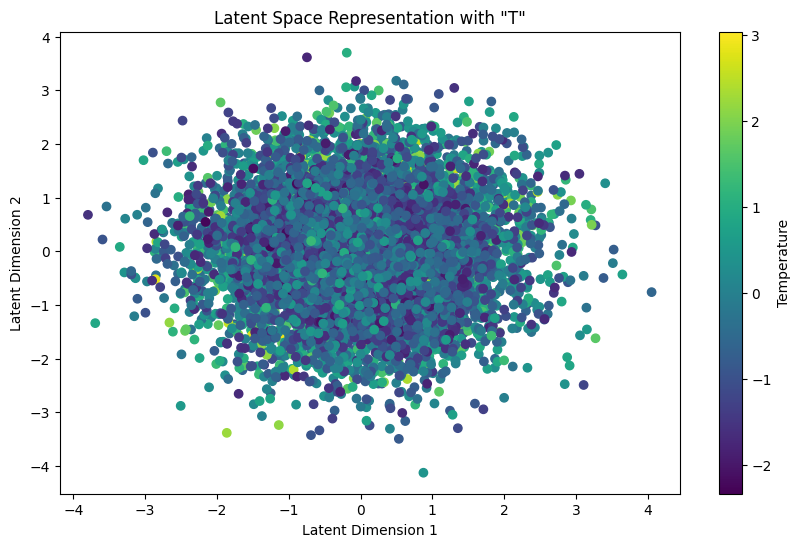

In [53]:
import matplotlib.pyplot as plt

latent_means = latent_representations[0]
latent_log_vars = latent_representations[1]
latent_space = latent_representations[2]  # Sampled latent space values
conditions = latent_representations[3]  # Condition outputs (T)

plt.figure(figsize=(10, 6))
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=conditions[:, 0], cmap='viridis')
plt.colorbar(label='Temperature')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Representation with "T"')
plt.show()


No strong relationship between "T" and the latent dimensions

In [54]:
import numpy as np

correlation_matrix = np.corrcoef(latent_space.T, conditions.T)
print("Correlation Matrix:\n", correlation_matrix)


Correlation Matrix:
 [[ 1.00000000e+00 -6.99318567e-04  9.14020889e-03]
 [-6.99318567e-04  1.00000000e+00  1.57330675e-02]
 [ 9.14020889e-03  1.57330675e-02  1.00000000e+00]]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


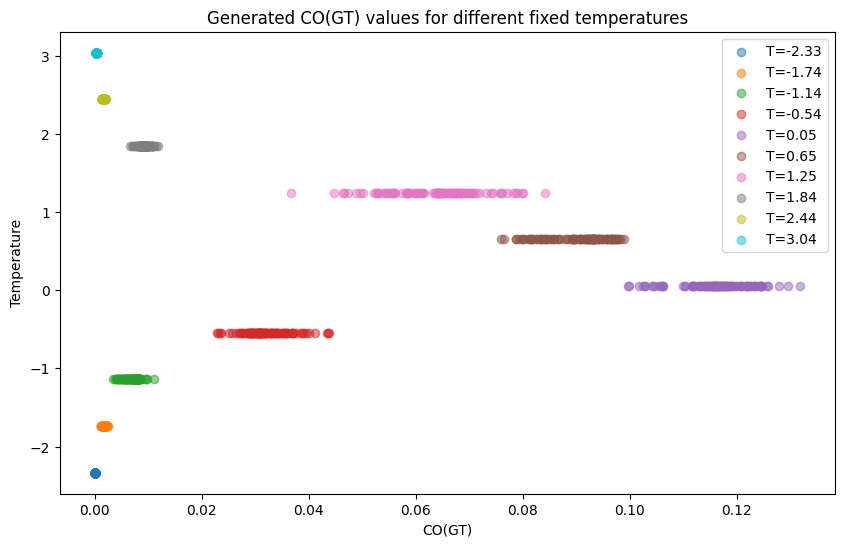

In [61]:
df = df.drop(columns= "datetime")
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

# Generate samples from the latent space
def generate_samples_with_fixed_temperature(vae, latent_dim, temperature_value, num_samples=100):
    latent_samples = np.random.normal(size=(num_samples, latent_dim))
    temperature_samples = np.full((num_samples, 1), temperature_value)
    generated_samples = vae.decode(latent_samples, temperature_samples)
    return generated_samples

temperature_index = 10  # 0-based index for "T" column
co_gt_index = 1  # 0-based index for "CO(GT)" column

# Define a range of temperature values to analyze
temperature_values = np.linspace(min(data_scaled[:, temperature_index]), max(data_scaled[:, temperature_index]), 10)

# Generate samples for each temperature value
generated_samples = []
for temp in temperature_values:
    samples = generate_samples_with_fixed_temperature(vae, latent_dim=2, temperature_value=temp)
    generated_samples.append(samples)

# Plotting the generated samples for different temperature values
plt.figure(figsize=(10, 6))
for i, temp in enumerate(temperature_values):
    plt.scatter(generated_samples[i][:, co_gt_index], [temp] * len(generated_samples[i]), label=f'T={temp:.2f}', alpha=0.5)

plt.xlabel('CO(GT)')
plt.ylabel('Temperature')
plt.title('Generated CO(GT) values for different fixed temperatures')
plt.legend()
plt.show()


In [62]:
from scipy.stats import pearsonr, spearmanr

# Calculate correlation coefficients
pearson_corr, _ = pearsonr(df['T'], df['CO(GT)'])
spearman_corr, _ = spearmanr(df['T'], df['CO(GT)'])

print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")


Pearson Correlation: 0.020260426393136216
Spearman Correlation: 0.07003305330226046


In [63]:
from statsmodels.tsa.stattools import grangercausalitytests

# Prepare data for Granger causality test
data_granger = df[['CO(GT)', 'T']].dropna()
max_lag = 2
test_result = grangercausalitytests(data_granger, max_lag, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0783  , p=0.7797  , df_denom=9353, df_num=1
ssr based chi2 test:   chi2=0.0783  , p=0.7796  , df=1
likelihood ratio test: chi2=0.0783  , p=0.7796  , df=1
parameter F test:         F=0.0783  , p=0.7797  , df_denom=9353, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9294  , p=0.3948  , df_denom=9350, df_num=2
ssr based chi2 test:   chi2=1.8597  , p=0.3946  , df=2
likelihood ratio test: chi2=1.8595  , p=0.3946  , df=2
parameter F test:         F=0.9294  , p=0.3948  , df_denom=9350, df_num=2


c:\Users\fengyong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


(p-value > 0.05) No Granger causality from Temperature to 'CO(GT)'.

### other validation

In [24]:
import warnings
from statsmodels.tsa.stattools import grangercausalitytests

temperature = latent_representations[3]

# Ensure temperature is in the correct shape
temperature = temperature.flatten()  # Flatten to ensure it's a 1D array

# Combine the data for the Granger causality test
# We'll test if Temperature (column 1) Granger-causes each latent dimension (columns 0 and 2)
data_for_granger = np.column_stack((latent_space, temperature))

warnings.simplefilter(action='ignore', category=FutureWarning)

def perform_granger_test(data, maxlag):
    results = {}
    for i in range(latent_space.shape[1]):
        print(f"\nGranger causality test for Latent Dimension {i+1}")
        try:
            test_result = grangercausalitytests(data[:, [i, -1]], maxlag=maxlag, verbose=True)
            results[i] = test_result
        except ValueError as e:
            print(f"ValueError: {e}")
    return results

# Perform the Granger causality test
# Testing if temperature Granger-causes the latent dimensions
maxlag = 2  # You can adjust this value
granger_results = perform_granger_test(data_for_granger, maxlag)

# Print summary of results
for i in granger_results:
    print(f"\nResults for Latent Dimension {i+1}:")
    for key in granger_results[i]:
        f_test = granger_results[i][key][0]['ssr_ftest']
        print(f"  Lag {key}: F-statistic = {f_test[0]:.4f}, p-value = {f_test[1]:.4f}")

# print("Shape of data_for_granger:", data_for_granger.shape)
# print("First few rows of data_for_granger:", data_for_granger[:5])


Granger causality test for Latent Dimension 1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1995  , p=0.6551  , df_denom=9353, df_num=1
ssr based chi2 test:   chi2=0.1996  , p=0.6551  , df=1
likelihood ratio test: chi2=0.1996  , p=0.6551  , df=1
parameter F test:         F=0.1995  , p=0.6551  , df_denom=9353, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5345  , p=0.5860  , df_denom=9350, df_num=2
ssr based chi2 test:   chi2=1.0695  , p=0.5858  , df=2
likelihood ratio test: chi2=1.0695  , p=0.5858  , df=2
parameter F test:         F=0.5345  , p=0.5860  , df_denom=9350, df_num=2

Granger causality test for Latent Dimension 2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8825  , p=0.1701  , df_denom=9353, df_num=1
ssr based chi2 test:   chi2=1.8831  , p=0.1700  , df=1
likelihood ratio test: chi2=1.8829  , p=0.1700  , df=1
parameter F test:         F=1.8825  , p=0.1701  , df_denom=9353, df_

(p-value > 0.05) No Granger causality from Temperature to the latent dimensions.

In [ ]:
'''
# Generate new samples by varying the temperature
new_latent_samples = np.random.normal(size=(10, 2))  # 10 new latent space samples
varying_conditions = np.linspace(-2, 2, 10).reshape(-1, 1)  # Vary temperature from -2 to 2 (scaled)

generated_samples = vae.decode(new_latent_samples, varying_conditions)

# Rescale generated samples back to the original scale
generated_samples_original = feature_scaler.inverse_transform(generated_samples)
'''

### Causal between "CO" and "T" (Just "CO" & "T", Granger Causality)

In [5]:
cols_to_drop = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)','NOx(GT)', 'PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)',
                'PT08.S5(O3)', 'RH', 'AH']
df_CO_T = df.drop(columns=cols_to_drop)
df_CO_T.head(2)

,datetime,CO(GT),T
0,2004-03-10 18:00:00,2.6,13.6
1,2004-03-10 19:00:00,2.0,13.3


In [6]:
# normalize data
# Assuming your dataset is stored in a DataFrame called df
# Extract "CO" and "T" columns
co_values = df_CO_T["CO(GT)"].values
t_values = df_CO_T["T"].values

# Normalize "CO" and "T" columns
co_mean, co_std = co_values.mean(), co_values.std()
t_mean, t_std = t_values.mean(), t_values.std()

df_CO_T["CO(GT)"] = (df_CO_T["CO(GT)"] - co_mean) / co_std
df_CO_T["T"] = (df_CO_T["T"] - t_mean) / t_std

print(df_CO_T.head(5))
df_CO_T.dtypes

             datetime    CO(GT)         T
0 2004-03-10 18:00:00  0.339856 -0.544709
1 2004-03-10 19:00:00 -0.116071 -0.579359
2 2004-03-10 20:00:00  0.035905 -0.741061
3 2004-03-10 21:00:00  0.035905 -0.845011
4 2004-03-10 22:00:00 -0.420023 -0.827686


datetime    datetime64[ns]
CO(GT)             float32
T                  float32
dtype: object

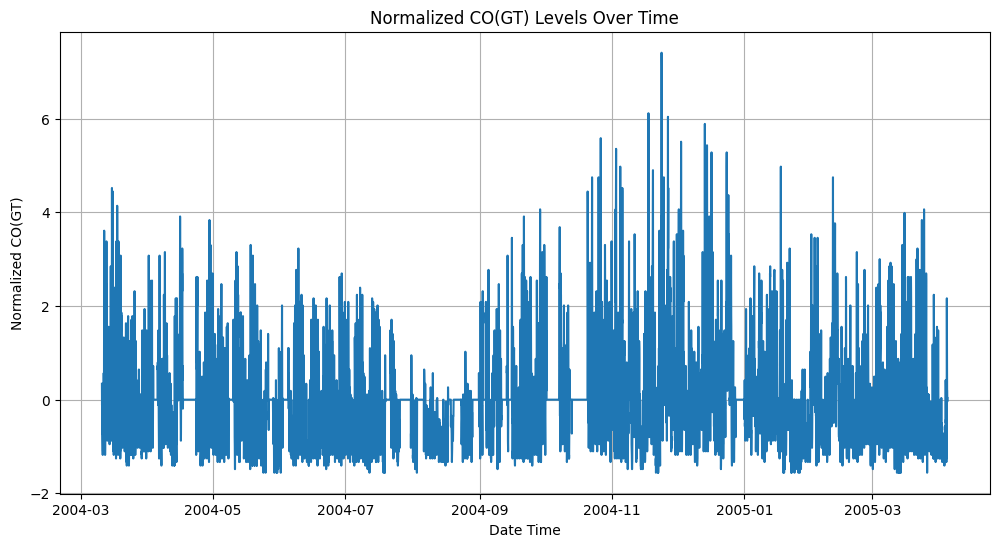

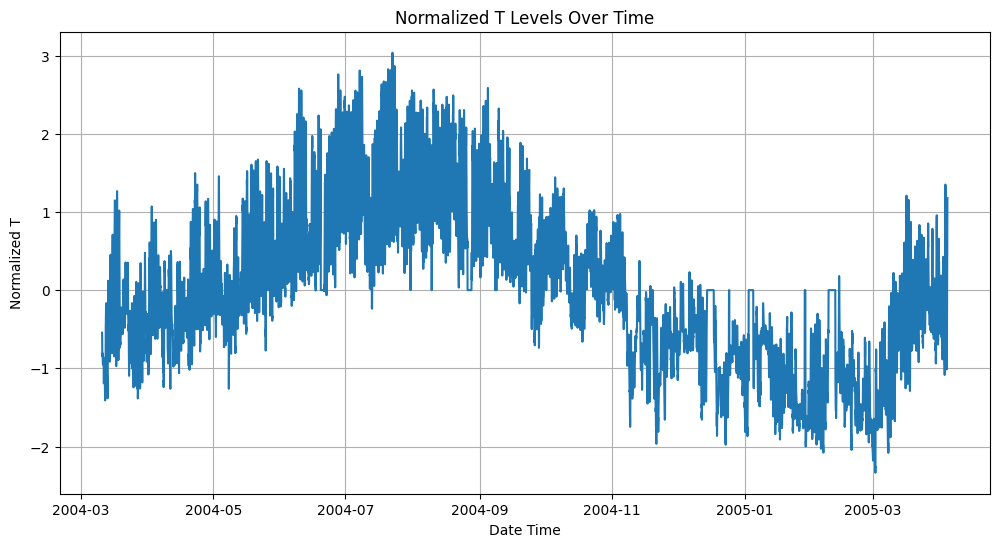

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df_CO_T["datetime"], df_CO_T["CO(GT)"])
plt.xlabel("Date Time")
plt.ylabel("Normalized CO(GT)")
plt.title("Normalized CO(GT) Levels Over Time")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_CO_T["datetime"], df_CO_T["T"])
plt.xlabel("Date Time")
plt.ylabel("Normalized T")
plt.title("Normalized T Levels Over Time")
plt.grid(True)
plt.show()


In [10]:
# Define VAE model
input_shape = (2,)  # Use input_shape as a tuple for the Input layer
latent_dim = 2        # 2D latent space for visualization

x_train = df_CO_T[['CO(GT)', 'T']].values
vae = VAE(input_shape, latent_dim)

vae.train(x_train, batch_size=128, epochs=20)

# Encode and decode some digits from the test set
encoded_data, _, _ = vae.encode(x_train)
decoded_data = vae.decode(encoded_data)


Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1133
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0006
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9949
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0172
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0018
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0102
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0270
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9988
Epoch 9/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9923
Epoch 10/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9954
Epoch 11/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9886
Epoch 12/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0051
Epoch 13/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9955
Epoch 14/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0084
Epoch 15/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9838
Epoch 16/20
74/74 

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming 'data' is your dataframe with datetime, CO(GT), and T columns
df_CO_T["datetime"] = pd.to_datetime(df_CO_T["datetime"])

# Extracting features from datetime
df_CO_T['year'] = df_CO_T['datetime'].dt.year
df_CO_T['month'] = df_CO_T['datetime'].dt.month
df_CO_T['day'] = df_CO_T['datetime'].dt.day
df_CO_T['hour'] = df_CO_T['datetime'].dt.hour

# df_CO_T['minute'] = df_CO_T['datetime'].dt.minute
# df_CO_T['second'] = df_CO_T['datetime'].dt.second

# Drop the original datetime column
df_CO_T = df_CO_T.drop('datetime', axis=1)

# Normalize the numerical features
scaler = StandardScaler()
df_CO_T[['CO(GT)', 'T']] = scaler.fit_transform(df_CO_T[['CO(GT)', 'T']])


In [14]:
print(df_CO_T[['CO(GT)', 'T']].size)
print(df_CO_T[['CO(GT)', 'T']].head(2))
print(df_CO_T.size)
print(df_CO_T.head(2))


18714
     CO(GT)         T
0  0.339856 -0.544709
1 -0.116071 -0.579359
28071
             datetime    CO(GT)         T
0 2004-03-10 18:00:00  0.339856 -0.544709
1 2004-03-10 19:00:00 -0.116071 -0.579359


In [17]:

# Reshape the data if necessary (e.g., if you're passing a single sample)
# data_reshaped = df_CO_T.values.reshape(1, 2)  # Assuming you have a single sample
#1, 74856, 18714, 9357*
data_reshaped = df_CO_T[['CO(GT)', 'T']].values.reshape(9357, 2)

# Now you can pass data_reshaped to the predict method of your VAE model
reconstructed_data = vae.predict(data_reshaped)


293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [18]:
reconstructed_data.size

18714

In [19]:
# Assuming 'vae' is your trained VAE model
#reconstructed_data = vae.predict(df_CO_T)
mse = np.mean(np.square(df_CO_T[['CO(GT)', 'T']] - reconstructed_data), axis=0)
print(mse)

CO(GT)    1.000005
T         0.999990
dtype: float32


In [20]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Assuming df is your preprocessed DataFrame with 'datetime' as the index
granger_results = grangercausalitytests(df_CO_T[['CO(GT)', 'T']], maxlag=1)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0783  , p=0.7797  , df_denom=9353, df_num=1
ssr based chi2 test:   chi2=0.0783  , p=0.7796  , df=1
likelihood ratio test: chi2=0.0783  , p=0.7796  , df=1
parameter F test:         F=0.0783  , p=0.7797  , df_denom=9353, df_num=1


In [ ]:
'''
from sklearn.decomposition import FastICA
# Define the number of independent components
n_components = 2

# Fit the FastICA object to the encoded data
ica = FastICA(n_components=n_components, random_state=0)
ica.fit(encoded_data)

# Transform the encoded data to obtain the independent components
independent_components = ica.transform(encoded_data)

print("Independent Components:")
print(independent_components)
'''

### features vs T

In [27]:
# Assuming you have already defined the VAE class

class VAEWithT(VAE):
    def __init__(self, input_shape, latent_dim):
        super().__init__(input_shape, latent_dim)
    
    def build_decoder(self):
        latent_inputs = Input(shape=(self.latent_dim,))
        
        hidden_layer1 = Dense(64, activation='relu')(latent_inputs)
        hidden_layer2 = Dense(128, activation='relu')(hidden_layer1)
        hidden_layer3 = Dense(256, activation='relu')(hidden_layer2)
        output_layer = Dense(len(self.input_shape), activation='linear')(hidden_layer3)  # Use 'linear' activation for 'T'

        decoder = Model(latent_inputs, output_layer, name='decoder')
        return decoder

    def build_vae(self):
        input_layer = Input(shape=self.input_shape)
        mean_layer, log_var_layer, latent_space = self.encoder(input_layer)
        reconstruction = self.decoder(latent_space)

        # Use the custom VAELossLayer, but use 'T' as the target for reconstruction
        output_with_loss = VAELossLayer()([input_layer[:, -1], reconstruction[:, -1], mean_layer, log_var_layer])

        vae = Model(input_layer, output_with_loss, name='vae')
        vae.compile(optimizer=Adam(learning_rate=0.001))
        return vae
    

In [22]:
input_shape = (5,)  # Use input_shape as a tuple for the Input layer
latent_dim = 2        # 2D latent space for visualization

df = pd.read_excel('AirQualityUCI.xlsx')
df['time_str'] = df['Time'].astype(str)
df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['time_str'])
df.drop(['Date', 'Time', 'time_str'], axis=1, inplace=True)
df.replace(-200, float('nan'), inplace=True)
df = df.drop(columns= "NMHC(GT)") # too many missing values
df = df.fillna(df.mean(numeric_only=True)) 
df = df.astype({col: 'float32' for col in df.select_dtypes('float64').columns})


In [23]:
co_values = df["CO(GT)"].values
t_values = df["T"].values

ch_values = df["C6H6(GT)"].values
no_values = df["NO2(GT)"].values
nox_values = df["NOx(GT)"].values

# Normalize columns
co_mean, co_std = co_values.mean(), co_values.std()
t_mean, t_std = t_values.mean(), t_values.std()
ch_mean, ch_std = ch_values.mean(), ch_values.std()
no_mean, no_std = no_values.mean(), no_values.std()
nox_mean, nox_std = nox_values.mean(), nox_values.std()

'''
"PT08.S1(CO)", "C6H6(GT)", "PT08.S2(NMHC)","NOx(GT)", "PT08.S3(NOx)",'NO2(GT)',"PT08.S4(NO2)",
        "PT08.S5(O3)","CO(GT)", "T"
'''

df["CO(GT)"] = (df["CO(GT)"] - co_mean) / co_std
df["T"] = (df["T"] - t_mean) / t_std
df["C6H6(GT)"] = (df["C6H6(GT)"] - ch_mean) / ch_std
df["NO2(GT)"] = (df["NO2(GT)"] - no_mean) / no_std
df["NOx(GT)"] = (df["NOx(GT)"] - nox_mean) / nox_std



In [28]:
x = df[['C6H6(GT)','NOx(GT)','NO2(GT)', 'CO(GT)', 'T']].values
vae = VAEWithT(input_shape, latent_dim)

# Train VAE model
vae.train(x, batch_size=128, epochs=20)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9574
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8820
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8556
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8547
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8465
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8606
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8298
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8384
Epoch 9/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8467
Epoch 10/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8537
Epoch 11/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8499
Epoch 12/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8358
Epoch 13/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8589
Epoch 14/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8373
Epoch 15/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8562
Epoch 16/20
74/74 ━

293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


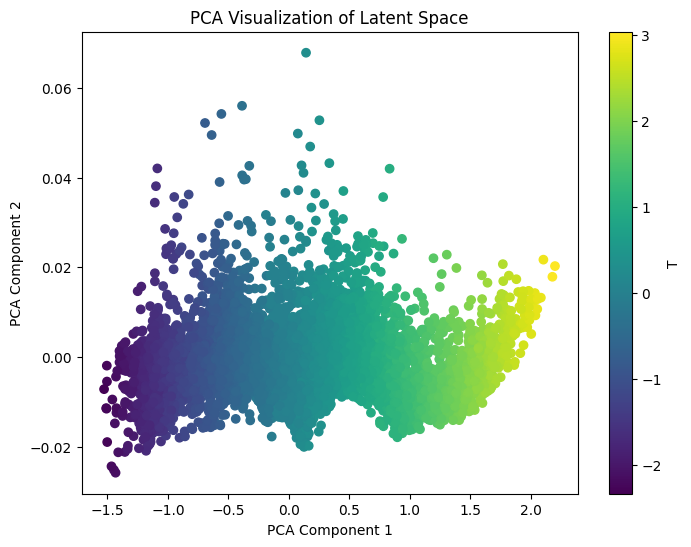

In [30]:
from sklearn.decomposition import PCA
# Encode the data into the latent space
encoded_data, _, _ = vae.encode(x)

# Analyze the latent space
# You can use clustering or visualization techniques (e.g., PCA, t-SNE) to analyze the encoded data points
pca = PCA(n_components=2)
encoded_data_pca = pca.fit_transform(encoded_data)

# Visualize the encoded data in the reduced-dimensional space
plt.figure(figsize=(8, 6))
plt.scatter(encoded_data_pca[:, 0], encoded_data_pca[:, 1], c=x[:, -1], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='T')
plt.title('PCA Visualization of Latent Space')
plt.show()


In [33]:
from sklearn.decomposition import FastICA

# Encode the data into the latent space
encoded_data, _, _ = vae.encode(x)

# Apply ICA to the encoded data
ica = FastICA(n_components=4, random_state=0)  # Assuming 3 components for illustration
ica_components = ica.fit_transform(encoded_data)

# Analyze the ICA components
# You can visualize the components or perform further analysis to understand their relationship with 'T' and other features


293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


c:\Users\fengyong\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_fastica.py:595: UserWarning: n_components is too large: it will be set to 2
  warnings.warn(


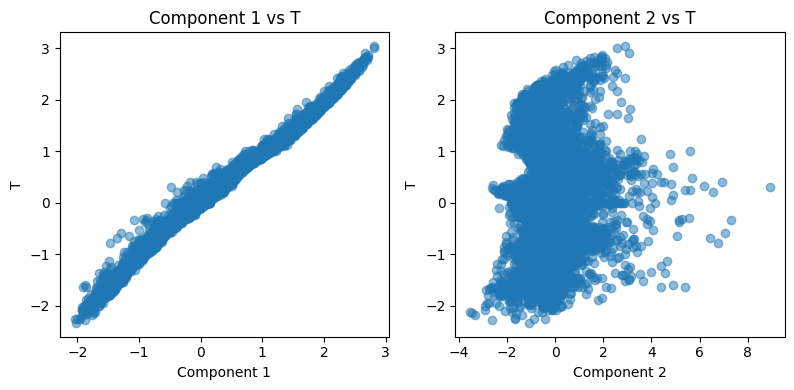

In [35]:
import seaborn as sns

# Assuming 3 components for illustration
component_names = ['Component 1', 'Component 2']
plt.figure(figsize=(12, 4))
for i in range(2):
    plt.subplot(1, 3, i+1)
    plt.scatter(ica_components[:, i], x[:, -1], alpha=0.5)
    plt.xlabel(component_names[i])
    plt.ylabel('T')
    plt.title(f"{component_names[i]} vs T")
plt.tight_layout()
plt.show()


In [ ]:
# Analyze the decoder weights
decoder_weights = vae.decoder.get_weights()  # Get the weights of the decoder
weights_for_T = decoder_weights[0][:, -1]  # Get the weights corresponding to 'T'

# Rank the columns based on the decoder weights
column_weights = {column: weights_for_T[i] for i, column in enumerate(['C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'CO(GT)', 'T'])}
sorted_columns = sorted(column_weights, key=lambda x: column_weights[x], reverse=True)

# Print the rank of columns based on their influence on 'T'
print("Rank of columns based on influence on 'T':")
for i, column in enumerate(sorted_columns):
    print(f"{i + 1}. {column}: {column_weights[column]}")


### VAE 2

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

# Ensure data is a numpy array for TensorFlow
data_scaled = np.array(data_scaled)

# Define and train the VAE
vae = VAE(input_shape=data_scaled.shape[1:], latent_dim=2)
vae.train(data_scaled, batch_size=32, epochs=100)

# After training, you can encode the data to get latent representations
latent_representations = vae.encode(data_scaled)

# You can now analyze the latent representations to explore potential relationships
print(latent_representations)

### Another (timestamp)

In [13]:
train_df = df[["CO(GT)", "T"]].copy()

In [ ]:
start_date = pd.Timestamp("2004-03-10 18:00:00")
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'] = (df['datetime'] - start_date) // pd.Timedelta('1s')

# Convert 'datetime' column to float
df['datetime'] = df['datetime'].astype(float)

normalized_df = (df - df.mean()) / df.std()
data = normalized_df.values
#dimensionality reduction
latent_dim = 2

# Instantiate the VAE model and optimizer
vae = VAE(latent_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Training loop
epochs = 10
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(len(data)).batch(batch_size)


### MNIST-VAE

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
from tensorflow.keras.layers import Layer

class VAELossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        
        input_layer, reconstruction, mean_layer, log_var_layer = inputs
        reconstruction_loss = MeanSquaredError()(input_layer, reconstruction)
        kl_loss = -0.5 * tf.reduce_sum(1 + log_var_layer - tf.square(mean_layer) - tf.exp(log_var_layer), axis=-1)
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(tf.reduce_mean(total_loss))
        return reconstruction



Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0970
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0675
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0673
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0674
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0674
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0674
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0673
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0674
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0673
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0674
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0673
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0674
Epoch 13/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0673
Epoch 14/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0674
Epoch 15/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - l

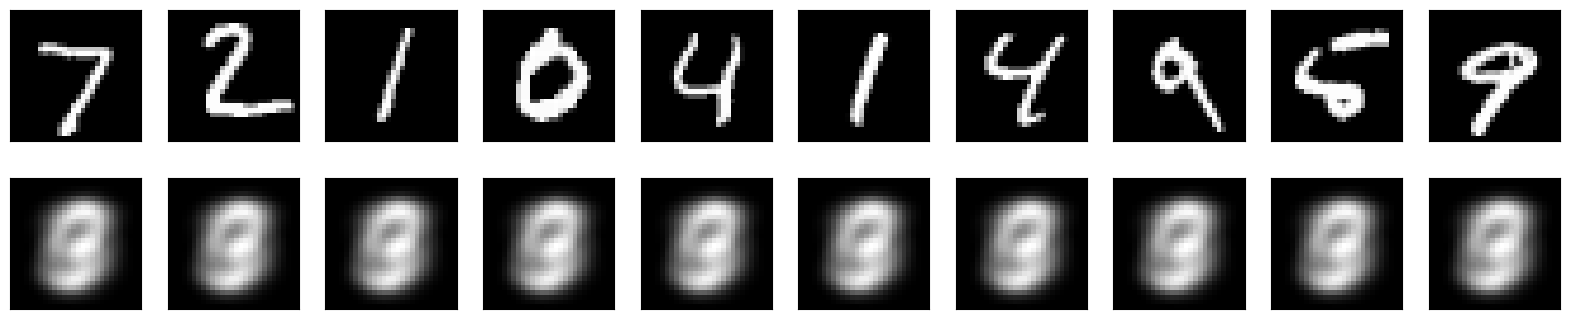

In [3]:
class VAE:
    def __init__(self, input_shape, latent_dim):

        self.input_shape = input_shape  # This should be a tuple
        
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.vae = self.build_vae()

    def build_encoder(self):
        input_layer = Input(shape=self.input_shape)
        hidden_layer1 = Dense(256, activation='relu')(input_layer)
        hidden_layer2 = Dense(128, activation='relu')(hidden_layer1)
        hidden_layer3 = Dense(64, activation='relu')(hidden_layer2)

        #  the mean of the Gaussian distribution in the latent space
        mean_layer = Dense(self.latent_dim)(hidden_layer3)

        # the log of the variance of the Gaussian distribution in the latent space
        log_var_layer = Dense(self.latent_dim)(hidden_layer3)

        # reparameterization
        def sampling(args):
            mean, log_var = args            # the mean and log variance of the latent distribution
            batch = tf.shape(mean)[0]       # computes the batch size from the shape of the mean tensor
            dim = tf.shape(mean)[1]         # computes the dimensionality of the latent space from the shape of the mean tensor

            # generates a tensor of random values from a standard normal distribution with the same shape as the mean tensor
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return mean + tf.exp(0.5 * log_var) * epsilon  # applies the reparameterization trick
                                                           # allows the model to backpropagate gradients through the sampling operation

        latent_space = Lambda(sampling)([mean_layer, log_var_layer])

        encoder = Model(input_layer, [mean_layer, log_var_layer, latent_space], name='encoder')
        return encoder

    def build_decoder(self):
        latent_inputs = Input(shape=(self.latent_dim,))
        
        hidden_layer1 = Dense(64, activation='relu')(latent_inputs)
        hidden_layer2 = Dense(128, activation='relu')(hidden_layer1)
        hidden_layer3 = Dense(256, activation='relu')(hidden_layer2)
        output_layer = Dense(np.prod(self.input_shape), activation='sigmoid')(hidden_layer3)

        decoder = Model(latent_inputs, output_layer, name='decoder')
        return decoder

    
    # In VAE class, modify the build_vae method to use the custom VAELossLayer
    def build_vae(self):
        input_layer = Input(shape=self.input_shape)
        mean_layer, log_var_layer, latent_space = self.encoder(input_layer)
        reconstruction = self.decoder(latent_space)

        # Use the custom VAELossLayer
        output_with_loss = VAELossLayer()([input_layer, reconstruction, mean_layer, log_var_layer])

        vae = Model(input_layer, output_with_loss, name='vae')
        vae.compile(optimizer=Adam(learning_rate=0.001))
        return vae


    def train(self, x_train, batch_size, epochs):
        self.vae.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1)

    def encode(self, x):
        return self.encoder.predict(x)

    def decode(self, z):
        return self.decoder.predict(z)

# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Flatten images for VAE input
x_train_flatten = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flatten = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

'''
# Define VAE model
input_dim = (x_train_flatten.shape[1],)
latent_dim = 2
vae = VAE(input_dim, latent_dim)
'''

# Define VAE model
input_shape = (784,)  # Use input_shape as a tuple for the Input layer
latent_dim = 2        # 2D latent space for visualization
vae = VAE(input_shape, latent_dim)



# Train VAE model
vae.train(x_train_flatten, batch_size=128, epochs=20)

# Encode and decode some digits from the test set
encoded_imgs, _, _ = vae.encode(x_test_flatten)
decoded_imgs = vae.decode(encoded_imgs)

# Display original and reconstructed images
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
